In [176]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from pandarallel import pandarallel
pandarallel.initialize(progress_bar = True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Import Data

In [49]:
# Read in raw data
rawdata_df = pd.read_csv('../data/taq/475f714f6936e98d_csv.zip')

In [177]:
rawdata_df.head()

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,SIZE,PRICE,TR_SOURCE
0,20200401,9:02:01.732097669,D,ANGL,NaN,11,25.30,N
1,20200401,9:28:01.017311122,K,ANGL,NaN,50,25.20,N
2,20200401,9:30:00.081856609,Q,ANGL,NaN,3637,25.05,N
3,20200401,9:30:00.081876534,Q,ANGL,NaN,3637,25.05,N
4,20200401,9:30:10.044836995,P,ANGL,NaN,2,25.02,N


In [51]:
rawdata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25366779 entries, 0 to 25366778
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   DATE        int64  
 1   TIME_M      object 
 2   EX          object 
 3   SYM_ROOT    object 
 4   SYM_SUFFIX  float64
 5   SIZE        int64  
 6   PRICE       float64
 7   TR_SOURCE   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 1.5+ GB


In [168]:
# Fed Trading data
fed_trading_df = pd.read_excel("../data/Trading_level_ETF.xlsx")

In [169]:
fed_trading_df.head()

,ETF Sponsor,Ticker,Fund Name,CUSIP Number,Trade Date,Contractual Settlement Date,Shares Purchased,Price per Share \n(US $),Broker Commission\n(US $),Purchase Amount\n(US $)
0,Vanguard,VCIT,Vanguard Intermediate-Term Corporate Bond ETF,92206C870,2020-05-12 00:00:00,2020-05-14 00:00:00,369117,90.6721,2583.82,33471197.36
1,BlackRock,HYG,iShares iBoxx High Yield Corporate Bond ETF,464288513,2020-05-12 00:00:00,2020-05-14 00:00:00,107417,79.8200,2148.34,8576173.28
2,BlackRock,SLQD,iShares 0-5 Year Investment Grade Corporate Bo...,46434V100,2020-05-12 00:00:00,2020-05-14 00:00:00,10906,51.3000,218.12,559695.92
3,Vanguard,VCSH,Vanguard Short-Term Corporate Bond ETF,92206C409,2020-05-12 00:00:00,2020-05-14 00:00:00,422597,81.0595,2958.18,34258459.70
4,State Street,SPSB,SPDR Portfolio Short Term Corporate Bond ETF,78464A474,2020-05-12 00:00:00,2020-05-14 00:00:00,75339,30.9500,1506.78,2333248.83


# Clean Data

## TAQ

### Volume

In [154]:
volumes_df = rawdata_df.copy()

In [155]:
# Add datetime info
volumes_df['date'] = pd.to_datetime(volumes_df['DATE'].astype(str))

In [156]:
# Rename variables
volumes_df.rename(columns = {'SYM_ROOT': 'ticker', 'PRICE': 'price', 'SIZE': 'size'}, inplace = True)

In [157]:
# Get daily volume for each ticker
volumes_df = volumes_df.groupby(['ticker', 'date'])['size'].sum().reset_index()

In [158]:
volumes_df.head()

,ticker,date,size
0,ANGL,2020-04-01,1371629
1,ANGL,2020-04-02,749849
2,ANGL,2020-04-03,1013295
3,ANGL,2020-04-06,2715488
4,ANGL,2020-04-07,2134791


### Prices

In [159]:
data_df_d = rawdata_df.query('EX == "D"').copy()
data_df = rawdata_df.query('EX != "D"').copy()

In [160]:
# Add datetime info
data_df['DATE TIME'] = data_df['DATE'].astype(str) + ' ' + data_df['TIME_M'].astype(str)
data_df['datetime'] = pd.to_datetime(data_df['DATE TIME'])
data_df['date'] = pd.to_datetime(data_df['DATE'].astype(str))

data_df_d['DATE TIME'] = data_df_d['DATE'].astype(str) + ' ' + data_df_d['TIME_M'].astype(str)
data_df_d['datetime'] = pd.to_datetime(data_df_d['DATE TIME'])
data_df_d['date'] = pd.to_datetime(data_df_d['DATE'].astype(str))

In [161]:
# Rename variables
data_df_d.rename(columns = {'SYM_ROOT': 'ticker', 'SIZE': 'size', 'PRICE': 'price'}, inplace = True)
data_df.rename(columns = {'SYM_ROOT': 'ticker', 'PRICE': 'price'}, inplace = True)

In [162]:
# Clean out times outside certain interval
temp2_df['hhmm_i'] = temp2_df['dt'].dt.hour*100 + temp2_df['dt'].dt.minute

In [163]:
# Resample on a 5 second basis
data_df = (
    data_df.set_index("datetime")
    .groupby(["ticker", "date"])
    .resample('5s', label = 'right')["price"]
    .last()
    .reset_index()
)


data_df["price"] = (
    data_df.sort_values(by="datetime")
    .groupby(["ticker", "date"])["price"]
    .fillna(method="ffill")
)

In [164]:
# Add more variables
data_df = data_df.sort_values(by="datetime")
data_df['log_price'] = np.log(data_df['price'])
data_df["return"] = data_df.groupby(["ticker", "date"])["log_price"].diff(1)

In [165]:
## RV
data_df = data_df.sort_values(["ticker", "date", "datetime"])

# data_df['RV_5s'] = (
#     data_df.groupby(["ticker", "date"])["return_squared"]
#     .rolling(5)
#     .sum()
#     .reset_index([0, 1], drop=True)
# )

In [166]:
data_df

,ticker,date,datetime,price,log_price,return
0,ANGL,2020-04-01,2020-04-01 09:28:05,25.2,3.226844,NaN
1,ANGL,2020-04-01,2020-04-01 09:28:10,25.2,3.226844,0.0
2,ANGL,2020-04-01,2020-04-01 09:28:15,25.2,3.226844,0.0
3,ANGL,2020-04-01,2020-04-01 09:28:20,25.2,3.226844,0.0
4,ANGL,2020-04-01,2020-04-01 09:28:25,25.2,3.226844,0.0
...,...,...,...,...,...,...
11369370,VCSH,2020-08-28,2020-08-28 17:16:55,83.0,4.418841,0.0
11369371,VCSH,2020-08-28,2020-08-28 17:17:00,83.0,4.418841,0.0
11369372,VCSH,2020-08-28,2020-08-28 17:17:05,83.0,4.418841,0.0
11369373,VCSH,2020-08-28,2020-08-28 17:17:10,83.0,4.418841,0.0


## Fed

In [170]:
fed_trading_df.columns = [
    "sponsor",
    "ticker",
    "ticker_desc",
    "CUSIP",
    "trade_date",
    "settle_date",
    "shares_purchased",
    "price_per_share",
    "broker_commission",
    "purchase_amount",
]

In [171]:
fed_trading_df['trade_date'] = pd.to_datetime(fed_trading_df['trade_date'])

In [172]:
fed_trading_df.head()

,sponsor,ticker,ticker_desc,CUSIP,trade_date,settle_date,shares_purchased,price_per_share,broker_commission,purchase_amount
0,Vanguard,VCIT,Vanguard Intermediate-Term Corporate Bond ETF,92206C870,2020-05-12,2020-05-14 00:00:00,369117,90.6721,2583.82,33471197.36
1,BlackRock,HYG,iShares iBoxx High Yield Corporate Bond ETF,464288513,2020-05-12,2020-05-14 00:00:00,107417,79.8200,2148.34,8576173.28
2,BlackRock,SLQD,iShares 0-5 Year Investment Grade Corporate Bo...,46434V100,2020-05-12,2020-05-14 00:00:00,10906,51.3000,218.12,559695.92
3,Vanguard,VCSH,Vanguard Short-Term Corporate Bond ETF,92206C409,2020-05-12,2020-05-14 00:00:00,422597,81.0595,2958.18,34258459.70
4,State Street,SPSB,SPDR Portfolio Short Term Corporate Bond ETF,78464A474,2020-05-12,2020-05-14 00:00:00,75339,30.9500,1506.78,2333248.83


# Process Data

## Identify Fed Purchases

In [16]:
def match_trade(data_df, trade_info):
    # Data_df is a dataframe of trades
    # trade_info is a pd.Series containing trade information: ticker, trade_date, shares_purchased

    # All trades that match the ticker, date, and size from trade_info
    matched_trades_df = data_df_d.query(
        "date == @trade_info.trade_date & size == @trade_info.shares_purchased & ticker == @trade_info.ticker"
    )

    # If there is more than one matched trade pick the first one with a price closest to the
    # price per share payed by the Fed
    if len(matched_trades_df) > 1:
        matched_trade = matched_trades_df.loc[
            (matched_trades_df["price"] - trade_info.price_per_share).idxmin(), :
        ]
        return matched_trade["datetime"]
    # Otherwise pull out the series observation from the df
    elif len(matched_trades_df) == 1:
        matched_trade = matched_trades_df.iloc[0]
        return matched_trade["datetime"]
    else:
        return pd.NaT

In [17]:
fed_trading_df["matched_trade_datetime"] = (
    fed_trading_df.parallel_apply(lambda x: match_trade(data_df, x), axis=1)
)

In [18]:
fed_trading_df.query('matched_trade_datetime == matched_trade_datetime')

,sponsor,ticker,ticker_desc,CUSIP,trade_date,settle_date,shares_purchased,price_per_share,broker_commission,purchase_amount,matched_trade_datetime
1,BlackRock,HYG,iShares iBoxx High Yield Corporate Bond ETF,464288513,2020-05-12,2020-05-14 00:00:00,107417,79.82,2148.34,8576173.28,2020-05-12 12:11:37.549827512
2,BlackRock,SLQD,iShares 0-5 Year Investment Grade Corporate Bo...,46434V100,2020-05-12,2020-05-14 00:00:00,10906,51.30,218.12,559695.92,2020-05-12 11:40:18.248027063
4,State Street,SPSB,SPDR Portfolio Short Term Corporate Bond ETF,78464A474,2020-05-12,2020-05-14 00:00:00,75339,30.95,1506.78,2333248.83,2020-05-12 11:28:54.585089482
5,State Street,JNK,SPDR Bloomberg Barclays High Yield Bond ETF,78468R622,2020-05-12,2020-05-14 00:00:00,79779,98.49,1595.58,7859029.29,2020-05-12 12:00:43.397499636
6,BlackRock,USHY,iShares Broad US Dollar High Yield Corporate B...,46435U853,2020-05-12,2020-05-14 00:00:00,27714,36.75,554.28,1019043.78,2020-05-12 13:39:08.861209824
...,...,...,...,...,...,...,...,...,...,...,...
921,BlackRock,IGIB,iShares Intermediate-Term Corporate Bond ETF,464288638,2020-07-23,07/27/2020,3594,61.20,71.88,220024.68,2020-07-23 10:49:19.939770694
922,BlackRock,SHYG,iShares 0-5 Year High Yield Corporate Bond ETF,46434V407,2020-07-23,07/27/2020,682,44.01,13.64,30028.46,2020-07-23 10:50:45.083333376
923,BlackRock,USHY,iShares Broad US Dollar High Yield Corporate B...,46435U853,2020-07-23,07/27/2020,1012,39.56,20.24,40054.96,2020-07-23 10:49:40.181395200
924,State Street,JNK,SPDR Bloomberg Barclays High Yield Bond ETF,78468R622,2020-07-23,07/27/2020,2574,104.93,51.48,270141.30,2020-07-23 10:46:29.375710464


In [37]:
def RV_from_prices(prices):
    # Gets RV from a series of prices

    return np.sum(np.log(prices).diff(1).apply(np.square).dropna())


def RV_event(data_df, event_ticker, event_date, event_datetime, event_window=int(30 * 60), price_freq=5):
    # Gets RV before and after an event; event window is the number (int) of seconds
    # before and after to consider; price_freq is the frequency at which to resample prices
    
    # Subset to relevant sample
    sample_df = data_df.query("ticker == @event_ticker & date == @event_date").copy()
    
    # Get returns in this sample
    sample_returns = np.log(sample_df.groupby(
        pd.Grouper(key="datetime", freq=str(price_freq) + "s", label="right", closed = 'right')
    )["price"].last()).diff(1).reset_index()
    sample_returns.columns = ['datetime', 'returns']
    
    # Boolean series indicating when trade occurred
    after_datetime_min = sample_returns["datetime"] >= (
        event_datetime - pd.Timedelta(str(event_window) + "s")
    )
    after_datetime_mid = sample_returns["datetime"] >= event_datetime
    after_datetime_max = sample_returns["datetime"] >= (
        event_datetime + pd.Timedelta(str(event_window) + "s")
    )
    
    RV_before = np.sum(np.square(sample_returns.loc[(after_datetime_min & (~after_datetime_mid)), 'returns']))
    RV_after = np.sum(np.square(sample_returns.loc[(~after_datetime_max & (after_datetime_mid)), 'returns']))
    
    return (RV_before, RV_after)

In [38]:
def RV_event_fp(data_df, event_ticker, event_date, event_datetime, event_window=int(30 * 60)):
    # Gets RV before and after an event; event window is the number (int) of seconds
    # before and after to consider; price_freq is the frequency at which to resample prices
    # Does not regenerate prices
    
    # Subset to relevant sample
    sample_df = data_df.query("ticker == @event_ticker & date == @event_date").copy()

    # Boolean series indicating when trade occurred
    after_datetime_min = sample_df["datetime"] >= (
        event_datetime - pd.Timedelta(str(event_window) + "s")
    )
    after_datetime_mid = sample_df["datetime"] >= event_datetime
    after_datetime_max = sample_df["datetime"] >= (
        event_datetime + pd.Timedelta(str(event_window) + "s")
    )

    RV_before = np.sum(sample_df.loc[(after_datetime_min & (~after_datetime_mid)), "return_squared"])
    RV_after = np.sum(sample_df.loc[(~after_datetime_max & (after_datetime_mid)), "return_squared"])

    return (RV_before, RV_after)

In [39]:
fed_trading_df.head()

,sponsor,ticker,ticker_desc,CUSIP,trade_date,settle_date,shares_purchased,price_per_share,broker_commission,purchase_amount,matched_trade_datetime,RV_before,RV_after
0,Vanguard,VCIT,Vanguard Intermediate-Term Corporate Bond ETF,92206C870,2020-05-12,2020-05-14 00:00:00,369117,90.6721,2583.82,33471197.36,NaT,NaN,NaN
1,BlackRock,HYG,iShares iBoxx High Yield Corporate Bond ETF,464288513,2020-05-12,2020-05-14 00:00:00,107417,79.8200,2148.34,8576173.28,2020-05-12 12:11:37.549827512,5.0,1.0
2,BlackRock,SLQD,iShares 0-5 Year Investment Grade Corporate Bo...,46434V100,2020-05-12,2020-05-14 00:00:00,10906,51.3000,218.12,559695.92,2020-05-12 11:40:18.248027063,5.0,1.0
3,Vanguard,VCSH,Vanguard Short-Term Corporate Bond ETF,92206C409,2020-05-12,2020-05-14 00:00:00,422597,81.0595,2958.18,34258459.70,NaT,NaN,NaN
4,State Street,SPSB,SPDR Portfolio Short Term Corporate Bond ETF,78464A474,2020-05-12,2020-05-14 00:00:00,75339,30.9500,1506.78,2333248.83,2020-05-12 11:28:54.585089482,5.0,1.0


In [43]:
data_df['return_squared'] = np.square(data_df['return'])
fed_trading_df['RV_before'], fed_trading_df['RV_after'] = zip(*fed_trading_df.parallel_apply(
    lambda x: (np.nan, np.nan)
    if pd.isnull(x["matched_trade_datetime"])
    else RV_event_fp(
        data_df,
        x["ticker"],
        x["trade_date"],
        x["matched_trade_datetime"],
        event_window=int(30*60),
    ),
    axis=1,
))

In [36]:
fed_trading_df.head()

,sponsor,ticker,ticker_desc,CUSIP,trade_date,settle_date,shares_purchased,price_per_share,broker_commission,purchase_amount
0,Vanguard,VCIT,Vanguard Intermediate-Term Corporate Bond ETF,92206C870,2020-05-12,2020-05-14 00:00:00,369117,90.6721,2583.82,33471197.36
1,BlackRock,HYG,iShares iBoxx High Yield Corporate Bond ETF,464288513,2020-05-12,2020-05-14 00:00:00,107417,79.8200,2148.34,8576173.28
2,BlackRock,SLQD,iShares 0-5 Year Investment Grade Corporate Bo...,46434V100,2020-05-12,2020-05-14 00:00:00,10906,51.3000,218.12,559695.92
3,Vanguard,VCSH,Vanguard Short-Term Corporate Bond ETF,92206C409,2020-05-12,2020-05-14 00:00:00,422597,81.0595,2958.18,34258459.70
4,State Street,SPSB,SPDR Portfolio Short Term Corporate Bond ETF,78464A474,2020-05-12,2020-05-14 00:00:00,75339,30.9500,1506.78,2333248.83


In [173]:
fed_trading_df = fed_trading_df.merge(
    volumes_df, left_on=["ticker", "trade_date"], right_on=["ticker", "date"], how="left"
).rename(columns={"size": "etf_daily_volume"})

In [41]:
fed_trading_df.to_csv('../data/clean/event_study_data.csv', index = False)

# Export Data

In [178]:
# Save price data
data_df.to_csv('../data/clean/prices.csv', index = False)

In [174]:
# Save daily RV
data_df['return_squared'] = np.square(data_df['return'])
RV_daily_df = data_df.groupby(['ticker', 'date'])['return_squared'].sum().reset_index()
RV_daily_df.rename(columns = {'return_squared': 'RV'}, inplace = True)
RV_daily_df.to_csv('../data/clean/RV_daily.csv', index = False)

In [175]:
# Save Fed trade data
fed_trading_df.to_csv('../data/clean/fed_trades.csv', index = False)

# Scratch

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

In [163]:
data_df['return_squared'] = np.square(data_df['return'])
RV_daily_df = data_df.groupby(['ticker', 'date'])['return_squared'].sum().reset_index()
RV_daily_df.rename(columns = {'return_squared': 'RV'}, inplace = True)

In [164]:
# True/false depending on whether fed purchased the ticker that day
RV_daily_df["fed_purchases"] = RV_daily_df.apply(
    lambda x: len(fed_trading_df.query("trade_date == @x.date & ticker == @x.ticker")) > 0, axis=1
)

In [165]:
# Add ticker descriptions
RV_daily_df = RV_daily_df.merge(fed_trading_df[['ticker', 'ticker_desc']], on  = 'ticker', how = 'left')
RV_daily_df['is_investment_grade'] = RV_daily_df['ticker_desc'].apply(lambda x: 'high' not in x.lower())

(0.0, 0.0002)

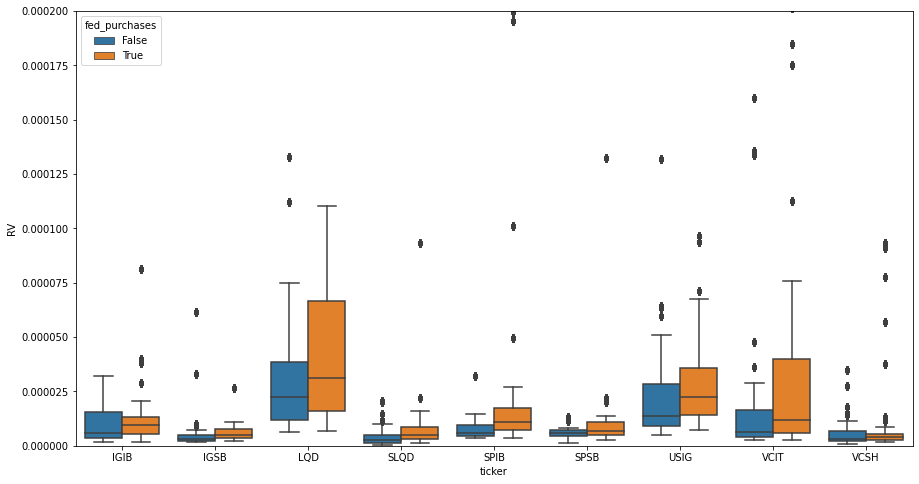

In [186]:
plt.figure(figsize=(15, 8))
sns.boxplot(
    x="ticker", y="RV", hue="fed_purchases", data=RV_daily_df.query("is_investment_grade == True")
)
plt.ylim(0, 2e-4)

(0.0, 0.0006)

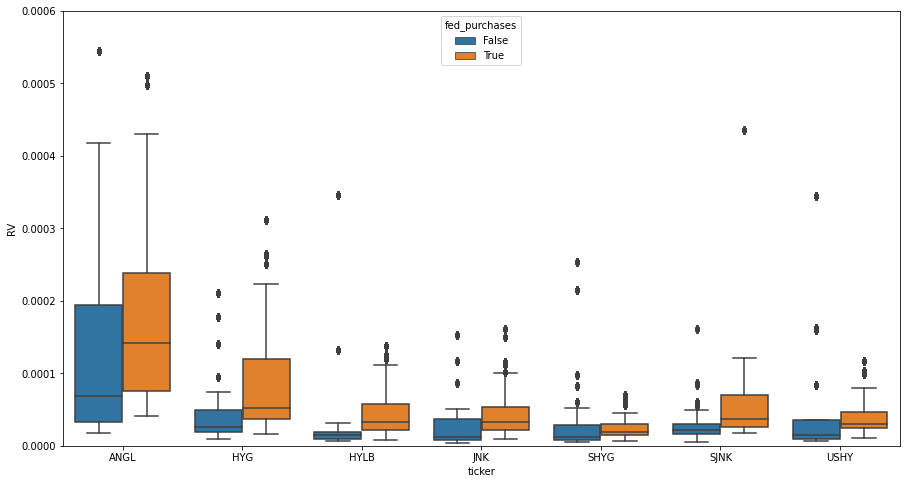

In [176]:
plt.figure(figsize=(15, 8))
sns.boxplot(
    x="ticker", y="RV", hue="fed_purchases", data=RV_daily_df.query("is_investment_grade == False")
)
plt.ylim(0, 0.0006)

In [178]:
import statsmodels.formula.api as smf

In [182]:
RV_daily_df.query('fed_purchases == False').describe()

,RV
count,3.599000e+04
mean,1.035508e-04
std,1.004914e-03
min,2.383266e-07
25%,4.743539e-06
50%,9.330146e-06
75%,2.277708e-05
max,2.152866e-02


In [181]:
RV_daily_df.query('fed_purchases == True').describe()

,RV
count,41794.000000
mean,0.000047
std,0.000143
min,0.000001
25%,0.000007
50%,0.000015
75%,0.000038
max,0.002339


In [184]:
9.330146e-06/0.000015

0.6220097333333333

In [180]:
smf.ols('RV ~ fed_purchases*is_investment_grade', RV_daily_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RV   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     260.0
Date:                Sun, 30 Aug 2020   Prob (F-statistic):          6.41e-168
Time:                        19:21:46   Log-Likelihood:             4.5596e+05
No. Observations:               77784   AIC:                        -9.119e+05
Df Residuals:                   77780   BIC:                        -9.119e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.0002   6.22e-06     36.529      0.000       0.000       0.000
fed_purchases[T.True]                                -0.0001   8.54e-06    -17.025      0.000      -0.000      -0.000
is_investment_grade[T.True]                          -0.0002   7.66e-06    -24.483      0.000      -0.000      -0.000
fed_purchases[T.True]:is_investment_grade[T.True]     0.0001   1.05e-05     12.970      0.000       0.000       0.000
==============================================================================
Omnibus:                   189833.526   Durbin-Watson:                   0.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1808486040.054
Skew:                          26.198   Prob(JB):                         0.00
Kurtosis:                     748.156   Cond. No.                         8.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
RV_daily_df.groupby(['ticker_desc', 'fed_purchases'])['RV'].describe()['mean'].reset_index()

,ticker_desc,fed_purchases,mean
0,SPDR Bloomberg Barclays High Yield Bond ETF,False,0.000026
1,SPDR Bloomberg Barclays High Yield Bond ETF,True,0.000044
2,SPDR Bloomberg Barclays Short Term High Yield ...,False,0.000027
3,SPDR Bloomberg Barclays Short Term High Yield ...,True,0.000069
4,SPDR Portfolio Intermediate Term Corporate Bon...,False,0.000101
5,SPDR Portfolio Intermediate Term Corporate Bon...,True,0.000036
6,SPDR Portfolio Short Term Corporate Bond ETF,False,0.000015
7,SPDR Portfolio Short Term Corporate Bond ETF,True,0.000015
8,VanEck Vectors Fallen Angel High Yield Bond ETF,False,0.000172
9,VanEck Vectors Fallen Angel High Yield Bond ETF,True,0.000220
